In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'


In [3]:
import os
from datetime import datetime
from PIL import Image
import tensorflow as tf
import time
from tensorflow.python.keras.callbacks import TensorBoard
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization
import gc
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import clear_output
import cv2
import matplotlib.cm as cm
from IPython.display import Image, display
import csv
from PIL.Image import fromarray
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from importlib import reload


2024-10-09 15:15:18.221534: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [4]:
SEED = 1234
tf.random.set_seed(SEED)  
# Get current working directory
cwd = os.getcwd()

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12562768373066977444
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5176817088
locality {
  bus_id: 1
  links {
  }
}
incarnation: 22041490314528343
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


2024-10-09 15:15:19.534301: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-09 15:15:19.534673: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-10-09 15:15:19.535346: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-10-09 15:15:19.584520: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-09 15:15:19.584634: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 na

In [6]:

def orthogonal_rot(image):
    img=np.rot90(image, np.random.choice([-1, 0, 1]))
    img=tf.keras.applications.efficientnet.preprocess_input(img)
    return img

apply_data_augmentation = True

# Create training ImageDataGenerator object
if apply_data_augmentation:
    train_data_gen = ImageDataGenerator(
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        zoom_range=[1.0,1.3],
                                        #fill_mode='nearest',
                                        #cval=0,
                                        preprocessing_function=orthogonal_rot,
                                        #rescale=1./255,
                                        #validation_split=0.2
                                        )

valid_data_gen = ImageDataGenerator(#horizontal_flip=True,
                                        #vertical_flip=True,
                                        #zoom_range=[1.0,1.3],
                                        #fill_mode='nearest',
                                        #cval=0,
                                        preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
                                        #rescale=1./255,
                                        #validation_split=0.2
)


test_data_gen = ImageDataGenerator(#horizontal_flip=True,
                                        #vertical_flip=True,
                                        #zoom_range=[1.0,1.3],
                                        #fill_mode='nearest',
                                        #cval=0,
                                        preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
                                        #rescale=1./255,
                                        #validation_split=0.2
)

In [7]:
# Create generators to read images from dataset directory
# -------------------------------------------------------
#dataset_dir = os.path.join(cwd,'labelled_datasets/dataset_1/')
dataset_dir = "/home/aislab/Documents/StakanovThesis/CODE/labelled_KTH+MIT_processed/"

# Batch size
bs = 8

# img shape
img_h = 500
img_w = 500

num_classes=2

decide_class_indices = True
if decide_class_indices:
    classes = ['NOT_EXPLORED',  # 0
                'EXPLORED'      # 1
               ]        
else:
    classes=None

# Training
training_dir = os.path.join(dataset_dir, 'train')
train_gen = train_data_gen.flow_from_directory(training_dir,
                                               batch_size=bs,
                                               target_size=(img_h,img_w),
                                               color_mode='rgb',
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=SEED
                                               #subset='training'
                                               )  

# Validation
validation_dir = os.path.join(dataset_dir, 'valid')
valid_gen = valid_data_gen.flow_from_directory(validation_dir,
                                               batch_size=bs, 
                                               target_size=(img_h,img_w),
                                               color_mode='rgb',
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=SEED
                                               #subset='validation'
                                               )

# Test
test_dir = os.path.join(dataset_dir, 'test')
test_gen = test_data_gen.flow_from_directory(test_dir,
                                               batch_size=bs, 
                                               target_size=(img_h,img_w),
                                               color_mode='rgb',
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=SEED
                                               #subset='validation'
                                               )





Found 3995 images belonging to 2 classes.
Found 73 images belonging to 2 classes.
Found 7848 images belonging to 2 classes.


In [8]:
# Check how keras assigned the labels
train_gen.class_indices
valid_gen.class_indices
test_gen.class_indices
train_gen.classes
valid_gen.classes
test_gen.classes


{'NOT_EXPLORED': 0, 'EXPLORED': 1}

{'NOT_EXPLORED': 0, 'EXPLORED': 1}

{'NOT_EXPLORED': 0, 'EXPLORED': 1}

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1], dtype=int32)

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [9]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))



Num GPUs Available:  1


2024-10-09 15:15:20.312693: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-10-09 15:15:20.312833: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-09 15:15:20.312949: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1060 6GB computeCapability: 6.1
coreClock: 1.7085GHz coreCount: 10 deviceMemorySize: 5.92GiB deviceMemoryBandwidth: 178.99GiB/s
2024-10-09 15:15:20.312972: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-10-09 15:15:20.312995: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-10-09 15:15:20.313007: I tensorflow/stream_executor/pla

In [10]:
enet = tf.keras.applications.EfficientNetB1(input_shape=(img_h,img_w,3),include_top=False,weights='imagenet')

start_f = 8
depth = 8

finetuning=True

if finetuning:
    freeze_until = 200 # layer from which fine-tuning starts
    
    for layer in enet.layers[:freeze_until]:
        layer.trainable = False
else:
    enet.trainable = False


model=tf.keras.Sequential()
model.add(enet)
model.add(Conv2D(1280,1,padding="same",activation='relu'))

model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(units=2, activation='softmax'))


2024-10-09 15:15:20.356829: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-10-09 15:15:20.357066: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-09 15:15:20.357187: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1060 6GB computeCapability: 6.1
coreClock: 1.7085GHz coreCount: 10 deviceMemorySize: 5.92GiB deviceMemoryBandwidth: 178.99GiB/s
2024-10-09 15:15:20.357212: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-10-09 15:15:20.357242: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-10-09 15:15:20.357256: I tensorflow/stream_executor/pla

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb1 (Functional)  (None, 16, 16, 1280)      6575239   
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 1280)      1639680   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 8,217,481
Trainable params: 7,442,166
Non-trainable params: 775,315
_________________________________________________________________


In [12]:
#Optimization parameters

#Learning rate
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(lr=lr)

#Validation metrics
metrics = ['accuracy']

#Compile model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metrics)

In [13]:
'''#THIS CELL CONTAINS THE CODE TO CREATE LOGS FOR TENSORFLOW, CHECKPOINTS AND EARLY STOPPING


cwd = os.getcwd()

exps_dir = '/media/mrk/TOSHIBA EXT/runs/DATASET/MODELS'
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'SIMPLE1'

exp_dir = exps_dir+'/'+ '_' + str(now)
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

#Model checkpoint
ckpt_dir = exp_dir+ '/'+'ckpts'
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=ckpt_dir+'/'+'cp_.ckpt',
                                                   save_weights_only=True)
callbacks.append(ckpt_callback)

#Visualize Learning on Tensorboard
#tb_dir = exp_dir+ '/'+'tb_logs'
#if not os.path.exists(tb_dir):
#    os.makedirs(tb_dir)
    
#By default shows losses and metrics for both training and validation
#tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
#                                             profile_batch=0,
#                                             histogram_freq=1)  # if 1 shows weights histograms
#callbacks.append(tb_callback)

#Early Stopping
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,restore_best_weights=True)
    callbacks.append(es_callback)'''

"#THIS CELL CONTAINS THE CODE TO CREATE LOGS FOR TENSORFLOW, CHECKPOINTS AND EARLY STOPPING\n\n\ncwd = os.getcwd()\n\nexps_dir = '/media/mrk/TOSHIBA EXT/runs/DATASET/MODELS'\nif not os.path.exists(exps_dir):\n    os.makedirs(exps_dir)\n\nnow = datetime.now().strftime('%b%d_%H-%M-%S')\n\nmodel_name = 'SIMPLE1'\n\nexp_dir = exps_dir+'/'+ '_' + str(now)\nif not os.path.exists(exp_dir):\n    os.makedirs(exp_dir)\n    \ncallbacks = []\n\n#Model checkpoint\nckpt_dir = exp_dir+ '/'+'ckpts'\nif not os.path.exists(ckpt_dir):\n    os.makedirs(ckpt_dir)\n\nckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=ckpt_dir+'/'+'cp_.ckpt',\n                                                   save_weights_only=True)\ncallbacks.append(ckpt_callback)\n\n#Visualize Learning on Tensorboard\n#tb_dir = exp_dir+ '/'+'tb_logs'\n#if not os.path.exists(tb_dir):\n#    os.makedirs(tb_dir)\n    \n#By default shows losses and metrics for both training and validation\n#tb_callback = tf.keras.callbacks.TensorBoard

In [14]:
callbacks = []

early_stop = True
tensorboard = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=12,restore_best_weights=True)
    callbacks.append(es_callback)
if tensorboard:
    tensorboard = TensorBoard(log_dir=os.path.join(cwd,'tensorboard_logs'))
    callbacks.append(tensorboard)

2024-10-08 18:33:13.821601: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-10-08 18:33:13.821622: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-10-08 18:33:13.821651: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 1 GPUs
2024-10-08 18:33:13.822327: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.10.1
2024-10-08 18:33:13.922841: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2024-10-08 18:33:13.923267: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


In [193]:
model.fit(train_gen,
steps_per_epoch=len(train_gen)//bs,
epochs=24,
verbose=1,
validation_data=valid_gen,
validation_steps=len(valid_gen)//bs,
callbacks=callbacks)

Epoch 1/24
  1/300 [..............................] - ETA: 29:12 - loss: 0.6803 - accuracy: 0.5000

2024-09-24 14:37:29.930425: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-09-24 14:37:29.930456: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-09-24 14:37:29.930525: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED


  2/300 [..............................] - ETA: 3:39 - loss: 0.6427 - accuracy: 0.5625 

2024-09-24 14:37:31.288417: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-09-24 14:37:31.313327: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2024-09-24 14:37:31.319585: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-09-24 14:37:31.325422: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /home/aislab/Documents/StakanovThesis/robot-aware-exploration/tensorboard_logs/train/plugins/profile/2024_09_24_14_37_31
2024-09-24 14:37:31.326568: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to /home/aislab/Documents/StakanovThesis/robot-aware-exploration/tensorboard_logs/train/plugins/profile/2024_09_24_14_37_31/aislab-XPS-8920.trace.json.gz
2024-09-24 14:37:31.384744: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating 

300/300 [==============================] - 115s 364ms/step - loss: 0.4409 - accuracy: 0.7788 - val_loss: 0.3019 - val_accuracy: 0.8606
Epoch 2/24
300/300 [==============================] - 106s 351ms/step - loss: 0.2387 - accuracy: 0.9143 - val_loss: 0.3382 - val_accuracy: 0.8567
Epoch 3/24
300/300 [==============================] - 107s 355ms/step - loss: 0.1907 - accuracy: 0.9227 - val_loss: 0.3013 - val_accuracy: 0.8731
Epoch 4/24
300/300 [==============================] - 121s 403ms/step - loss: 0.2009 - accuracy: 0.9273 - val_loss: 0.2564 - val_accuracy: 0.8990
Epoch 5/24
300/300 [==============================] - 108s 361ms/step - loss: 0.2082 - accuracy: 0.9180 - val_loss: 0.2848 - val_accuracy: 0.8894
Epoch 6/24
300/300 [==============================] - 107s 356ms/step - loss: 0.1756 - accuracy: 0.9326 - val_loss: 0.1653 - val_accuracy: 0.9250
Epoch 7/24
300/300 [==============================] - 106s 354ms/step - loss: 0.1481 - accuracy: 0.9519 - val_loss: 0.4421 - val_accura

In [194]:
%load_ext tensorboard
%tensorboard --logdir tensorboard_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 11763), started 2:02:49 ago. (Use '!kill 11763' to kill it.)

In [14]:
# model_save_path = os.path.join(cwd,'checkpoint_weights', 'weights_classification')
# if not os.path.exists(model_save_path):
#     os.makedirs(model_save_path)
# model.save_weights(os.path.join(model_save_path,'weights_combined.h5'))

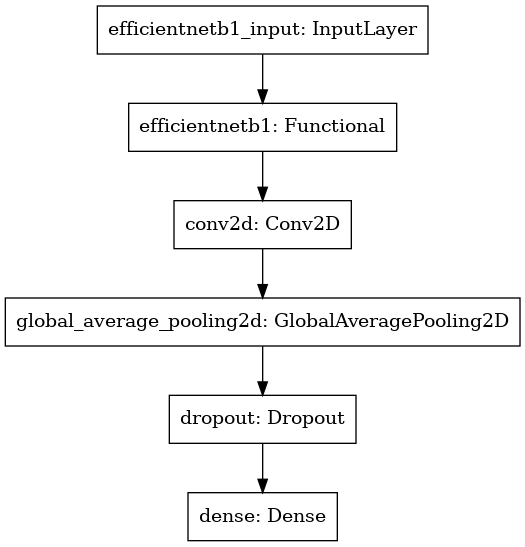

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


981
(8, 500, 500, 3)


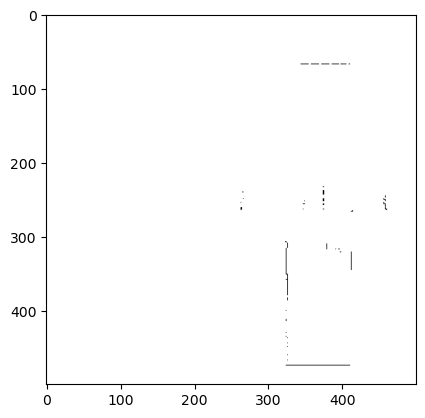

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


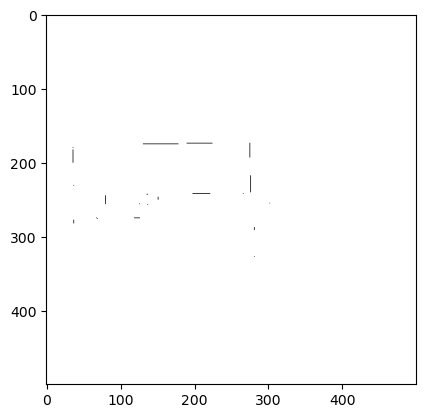

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


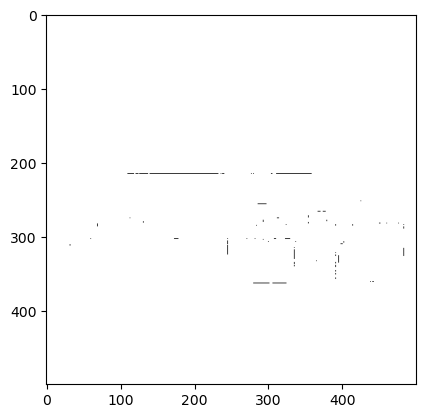

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


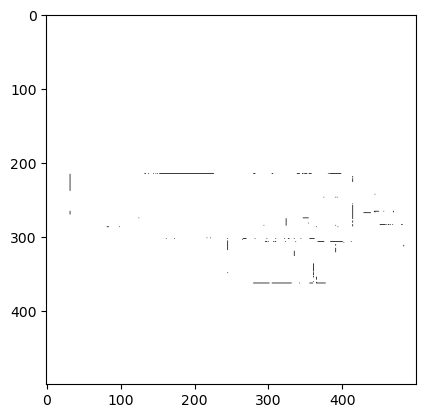

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


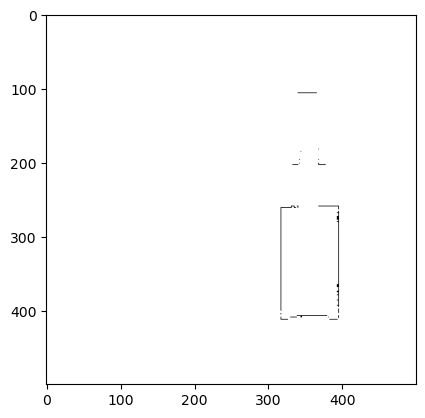

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


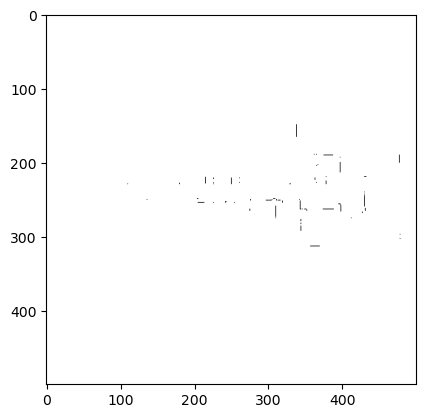

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


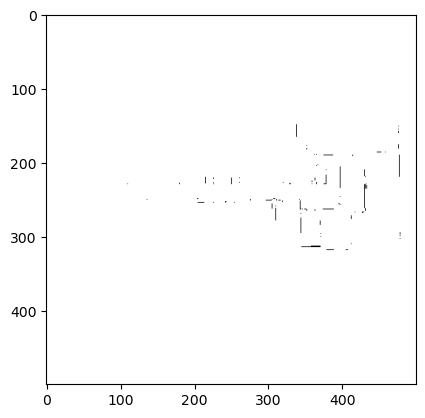

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


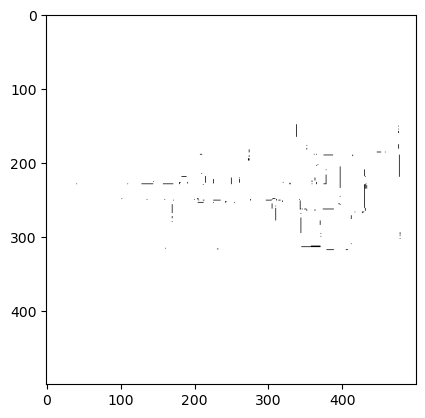

In [16]:
print(len(test_gen))
print(test_gen.next()[0].shape)
z= test_gen.next()
for i in range(0,8):
    plt.imshow(z[0][i])
    plt.show()


In [17]:
#model_load_path = os.path.join(cwd,'checkpoint_weights','weights_1.h5')
model_load_path = "/home/aislab/Documents/StakanovThesis/robot-aware-exploration/checkpoint_weights/weights_classification/weights_old.h5"
model.load_weights(model_load_path)

In [18]:
import time
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# tf.config.set_visible_devices([], 'GPU')

print(tf.config.list_physical_devices('GPU'))
#start_time = time.time()

pred=model.predict(test_gen,verbose=1)

#end_time = time.time()
#time_per_10 = end_time - start_time
#print(time_per_10)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-10-09 15:15:40.774007: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-10-09 15:15:40.795938: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600000000 Hz
2024-10-09 15:15:42.040416: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-10-09 15:15:42.154512: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2024-10-09 15:15:42.650399: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2024-10-09 15:15:42.692516: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


981/981 [==============================] - 167s 150ms/step


In [19]:
print(pred)
print(len(test_gen.classes))
print(np.unique(pred.argmax(axis=1)))


[[0.6704946  0.32950535]
 [0.9315075  0.06849245]
 [0.84554976 0.15445021]
 ...
 [0.08575084 0.9142491 ]
 [0.08566947 0.91433054]
 [0.08566947 0.91433054]]
7848
[0 1]


In [20]:
test_gen.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [21]:
import time
from sklearn import metrics
#Confusion Matrix
pred_classes=[]
thresh = 0.5
for i in pred:
    if i[1]>=thresh:
        pred_classes.append(1)
    else:
        pred_classes.append(0)


timestr = time.strftime("%Y:%m:%d-%H:%M:%S")
timestr = timestr+'-'+str(thresh)+'.csv'
print(timestr)

matrix = metrics.confusion_matrix(test_gen.classes,pred_classes) #Number of correctly classified images per class
accuracy = metrics.accuracy_score(test_gen.classes,pred_classes)
precision = metrics.precision_score(test_gen.classes,pred_classes)
recall = metrics.recall_score(test_gen.classes,pred_classes)
print(type(matrix))
print(matrix.shape)

matrix_percent=matrix/ matrix.sum(axis=0)                #Percentage of correct classifications per class
print(matrix)
print(matrix_percent)
print('ACCURACY: ',accuracy)
print('PRECISION: ',precision)
print('RECALL: ',recall)



2024:10:09-15:18:28-0.5.csv
<class 'numpy.ndarray'>
(2, 2)
[[3850  887]
 [ 401 2710]]
[[0.90566925 0.24659438]
 [0.09433075 0.75340562]]
ACCURACY:  0.835881753312946
PRECISION:  0.7534056157909369
RECALL:  0.8711025393764062


In [22]:
#save confusion matrix

with open(os.path.join(cwd,'Results','Confusion_Matrices',timestr), 'w') as f:
    # create the csv writer
    writer = csv.writer(f)

    # write confusion matrices (#images and percentages)
    writer.writerow(['Threshold',thresh,''])
    writer.writerow(['','Positive','Negative'])
    writer.writerow(['True',int(matrix[1][1]),int(matrix[0][0])])
    writer.writerow(['False',int(matrix[0][1]),int(matrix[1][0])])
    writer.writerow(['','',''])
    
    writer.writerow(['TN vs FN',float(matrix_percent[0][0]),float(matrix_percent[1][0])])
    writer.writerow(['TP vs FP',float(matrix_percent[1][1]),float(matrix_percent[0][1])])
    writer.writerow(['','',''])
    
    writer.writerow(['Accuracy',accuracy,''])
    writer.writerow(['Precision',precision,''])
    writer.writerow(['Recall',recall,''])

# TN FP
# FN TP


16

20

16

15

4

48

48

4

29

31

28

In [23]:
print(pred)

[[0.6704946  0.32950535]
 [0.9315075  0.06849245]
 [0.84554976 0.15445021]
 ...
 [0.08575084 0.9142491 ]
 [0.08566947 0.91433054]
 [0.08566947 0.91433054]]


In [40]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

import scipy.ndimage as ndimage
import csv

In [41]:
print(pred)

[[0.6704946  0.32950535]
 [0.9315075  0.06849245]
 [0.84554976 0.15445021]
 ...
 [0.08575084 0.9142491 ]
 [0.08566947 0.91433054]
 [0.08566947 0.91433054]]


In [59]:
def find_target_layer(self):
		for layer in reversed(self.layers):
			if len(layer.output_shape) == 4:
				return layer.name
		raise ValueError("Could not find last conv layer")

def get_img_array(img_path, size):
    img=tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array=tf.keras.preprocessing.image.img_to_array(img)

    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1,2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = cv2.resize(heatmap.numpy(),(img_h,img_w),interpolation= cv2.INTER_CUBIC)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    normilized_heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return (heatmap, normilized_heatmap)


def plot_gradcam_3d(heatmap, img_h, img_w):
    # Create X, Y coordinates
    x = np.linspace(0, img_w, heatmap.shape[1])
    y = np.linspace(0, img_h, heatmap.shape[0])
    X, Y = np.meshgrid(x, y)
    
    # Plot 3D surface with heatmap as Z axis
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    Z = heatmap 
    # Normalize heatmap for better visualization
    # Z = heatmap - np.min(heatmap)
    # Z = Z / np.max(Z)

    # Plot the surface
    ax.plot_surface(X, Y, Z, cmap='jet', edgecolor='none')

    # Add labels and colorbar
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Intensity (Z)')
    plt.colorbar(ax.plot_surface(X, Y, Z, cmap='jet', edgecolor='none'))
    plt.show()


def save_and_display_gradcam(img_path, heatmap, cam_path, alpha=0.5):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    #heatmap = np.uint8(255 * heatmap)
    heatmap = np.uint8(255*heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)



def find_groups_above_threshold(heatmap, threshold):
    # Apply a threshold to the heatmap
    thresholded_heatmap = heatmap >= threshold
    
    # Label the connected components in the thresholded heatmap
    labeled_array, num_features = ndimage.label(thresholded_heatmap)
    
    return labeled_array, num_features

def compute_average_intensity_per_group(heatmap, labeled_array, num_features):
    # Compute the average intensity for each labeled group
    average_intensities = ndimage.mean(heatmap, labeled_array, index=np.arange(1, num_features + 1))
    
    return average_intensities


def save_labeled_groups_to_csv(labeled_array, average_intensities, labels_file="labeled_array.csv", intensities_file="average_intensities.csv"):
    # Save labeled array to CSV
    np.savetxt(labels_file, labeled_array, fmt='%d', delimiter=',')
    
    # Save average intensities to CSV
    with open(intensities_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Group", "Average Intensity"])
        for i, avg_intensity in enumerate(average_intensities):
            writer.writerow([i + 1, avg_intensity])


threshold_value = 0.1


In [60]:
# If gradcam == True -> save the gradcam image
# Else -> save the image without superimposing the heatmap
gradcam=True
#Threshold between 0 and 1. Move towards 1 to reduce false positives
prediction_threshold=0.5

47

6-1@run1@8.0Map


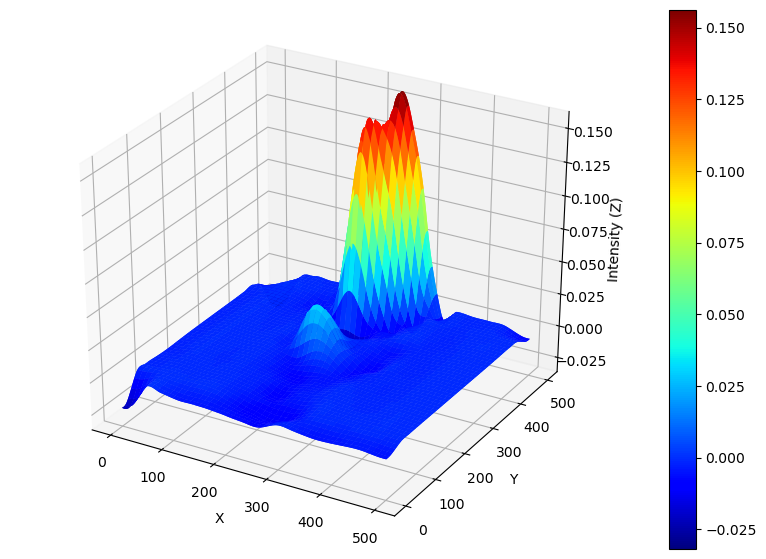

In [66]:
#print(x)
#test_dir_NOT_EX=os.path.join(cwd,'labelled_datasets','dataset_1','test','NOT_EXPLORED')
import time
test_dir_NOT_EX = "/home/aislab/Documents/StakanovThesis/robot-aware-exploration/Datasets/Labelled_Data/KTH+MIT_testiruem/test/NOT_EXPLORED"
save_dir_EX=os.path.join(cwd,'Results','GradCAM_predictions','KTH+MIT_test','EXPLORED_NE')
save_dir_NOT_EX=os.path.join(cwd,'Results','GradCAM_predictions','KTH+MIT_test','NOT_EXPLORED_NE')

if not os.path.exists(save_dir_EX):
    os.makedirs(save_dir_EX)

if not os.path.exists(save_dir_NOT_EX):
    os.makedirs(save_dir_NOT_EX)

with open(os.path.join(cwd,'Results','Confusion_Matrices','predictions_KTH+MIT_test.csv'), 'w') as f:

    writer=csv.writer(f)
    header=['image_name','prediction_NOT_EX','prediction_EX','class_id','type']
    writer.writerow(header)


    for img in os.listdir(test_dir_NOT_EX):
        img_path=os.path.join(test_dir_NOT_EX,img)
        full_img_path=img_path
        tmp=cv2.imread(img_path,1)
        tmp=cv2.resize(tmp,(img_h,img_w),interpolation=cv2.INTER_AREA)
        not_grad_img=tmp
        tmp=tf.keras.applications.efficientnet.preprocess_input(tmp)
        full_name=img_path.replace("/","_")
        full_name=full_name[len(test_dir_NOT_EX)+1:]
        tmp = np.expand_dims(tmp, axis=0)
        prediction=model.predict(tmp)
        max_index=np.argmax(prediction[0])

        last_conv_layer_name=find_target_layer(model)
        img_array = tf.keras.applications.efficientnet.preprocess_input(get_img_array(full_img_path, size=(img_h,img_w)))
        model.layers[-1].activation =None
        

        
        if(prediction[0][1]<=prediction_threshold):
            if gradcam==True:
                writer.writerow([img,prediction[0][0],prediction[0][1],0,'TN'])
                heatmap, normilized_heatmap = make_gradcam_heatmap(img_array,model,last_conv_layer_name,0)
                # Find groups above threshold
                labeled_array, num_features = find_groups_above_threshold(heatmap, threshold_value)

                # Compute average intensity per group
                average_intensities = compute_average_intensity_per_group(heatmap, labeled_array, num_features)
                #plt.matshow(heatmap)
                #plt.show()
                save_and_display_gradcam(full_img_path, normilized_heatmap,os.path.join(save_dir_NOT_EX,full_name))
                save_labeled_groups_to_csv(labeled_array, average_intensities, f"{os.path.join(save_dir_NOT_EX,full_name[:-4])}_labeled_array.csv", f"{os.path.join(save_dir_NOT_EX,full_name)}_average_intensities.csv") 

            else:
                cv2.imwrite(os.path.join(save_dir_NOT_EX,full_name),not_grad_img)
        else:
            if gradcam==True:
                writer.writerow([img,prediction[0][0],prediction[0][1],1,'FP'])
                heatmap, normilized_heatmap = make_gradcam_heatmap(img_array,model,last_conv_layer_name,1)
                # Find groups above threshold
                labeled_array, num_features = find_groups_above_threshold(heatmap, threshold_value)

                # Compute average intensity per group
                average_intensities = compute_average_intensity_per_group(heatmap, labeled_array, num_features)
                #plt.matshow(heatmap)
                #plt.show()
                save_and_display_gradcam(full_img_path, normilized_heatmap, os.path.join(save_dir_EX,full_name))
                save_labeled_groups_to_csv(labeled_array, average_intensities, f"{os.path.join(save_dir_EX,full_name[:-4])}_labeled_array.csv", f"{os.path.join(save_dir_EX,full_name)}_average_intensities.csv") 

            else:
                cv2.imwrite(os.path.join(save_dir_EX,full_name),not_grad_img)
                
        
        print(full_name[:-4])
        img_h, img_w = heatmap.shape
        plot_gradcam_3d(heatmap, img_h, img_w)
        time.sleep(5)
        clear_output(wait=True)

50

6-1@run1@13.0Map.png


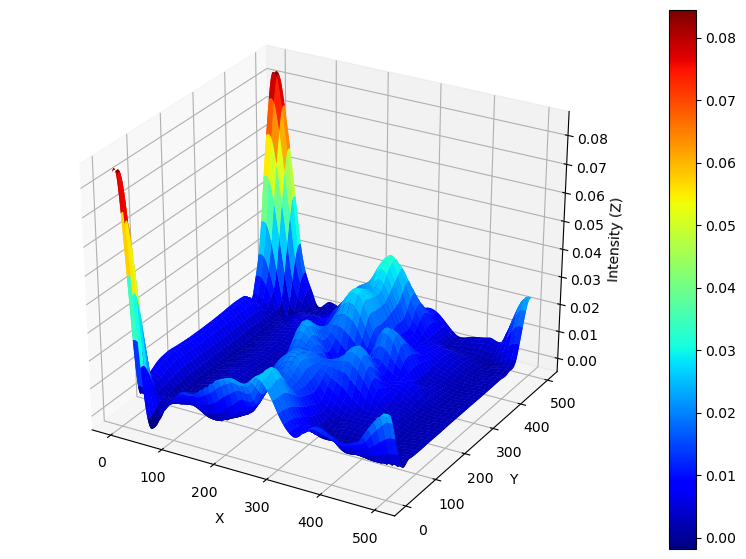

In [67]:
#print(x)
#test_dir_EX=os.path.join(cwd,'labelled_datasets','dataset_1','test','EXPLORED')
test_dir_EX = "/home/aislab/Documents/StakanovThesis/robot-aware-exploration/Datasets/Labelled_Data/KTH+MIT_testiruem/test/EXPLORED"

save_dir_EX=os.path.join(cwd,'Results','GradCAM_predictions','KTH+MIT_test','EXPLORED_E')
save_dir_NOT_EX=os.path.join(cwd,'Results','GradCAM_predictions','KTH+MIT_test', 'NOT_EXPLORED_E')

if not os.path.exists(save_dir_EX):
    os.makedirs(save_dir_EX)

if not os.path.exists(save_dir_NOT_EX):
    os.makedirs(save_dir_NOT_EX)



with open(os.path.join(cwd,'Results','Confusion_Matrices','predictions_KTH+MIT_test.csv'), 'a') as f:
    writer=csv.writer(f)


    for img in os.listdir(test_dir_EX):
        img_path=os.path.join(test_dir_EX,img)
        full_img_path=img_path
        tmp=cv2.imread(img_path,1)
        tmp=cv2.resize(tmp,(img_h,img_w),interpolation=cv2.INTER_AREA)
        not_grad_img=tmp
        tmp=tf.keras.applications.efficientnet.preprocess_input(tmp)
        full_name=img_path.replace("/","_")
        full_name=full_name[len(test_dir_EX)+1:]
        tmp = np.expand_dims(tmp, axis=0)
        prediction=model.predict(tmp)
        max_index=np.argmax(prediction[0])

        last_conv_layer_name=find_target_layer(model)
        img_array = tf.keras.applications.efficientnet.preprocess_input(get_img_array(full_img_path, size=(img_h,img_w)))
        model.layers[-1].activation =None

        
        if(prediction[0][1]<=prediction_threshold):
            if gradcam==True:
                writer.writerow([img,prediction[0][0],prediction[0][1],0,'FN'])
                heatmap, normilized_heatmap= make_gradcam_heatmap(img_array,model,last_conv_layer_name,0)
                # Find groups above threshold
                labeled_array, num_features = find_groups_above_threshold(heatmap, threshold_value)

                # Compute average intensity per group
                average_intensities = compute_average_intensity_per_group(heatmap, labeled_array, num_features)
                #plt.matshow(heatmap)
                #plt.show()
                save_and_display_gradcam(full_img_path,normilized_heatmap,os.path.join(save_dir_NOT_EX,full_name))
                save_labeled_groups_to_csv(labeled_array, average_intensities, f"{os.path.join(save_dir_NOT_EX,full_name[:-4])}_labeled_array.csv", f"{os.path.join(save_dir_NOT_EX,full_name)}_average_intensities.csv") 
            else:
                cv2.imwrite(os.path.join(save_dir_NOT_EX,full_name),not_grad_img)
        else:
            if gradcam==True:
                writer.writerow([img,prediction[0][0],prediction[0][1],1,'TP'])
                heatmap, normilized_heatmap= make_gradcam_heatmap(img_array,model,last_conv_layer_name,1)
                # Find groups above threshold
                labeled_array, num_features = find_groups_above_threshold(heatmap, threshold_value)

                # Compute average intensity per group
                average_intensities = compute_average_intensity_per_group(heatmap, labeled_array, num_features)
                #plt.matshow(heatmap)
                #plt.show()
                save_and_display_gradcam(full_img_path,normilized_heatmap,os.path.join(save_dir_EX,full_name))
                save_labeled_groups_to_csv(labeled_array, average_intensities, f"{os.path.join(save_dir_EX,full_name[:-4])}_labeled_array.csv", f"{os.path.join(save_dir_EX,full_name)}_average_intensities.csv") 
            else:
                cv2.imwrite(os.path.join(save_dir_EX,full_name),not_grad_img)
        
        print(full_name)
        img_h, img_w = heatmap.shape
        plot_gradcam_3d(heatmap, img_h, img_w)
        time.sleep(5)
        clear_output(wait=True)



In [56]:
def preproc(image):
    print(image)
    image=cv2.imread(image,cv2.IMREAD_GRAYSCALE)
    mean=image.mean()
    return mean
    

In [35]:
explored_mean_list=[]
not_explored_mean_list=[]
#exp_fold=os.path.join(cwd,'labelled_datasets','dataset_1','train','EXPLORED')
#not_exp_fold=os.path.join(cwd,'labelled_datasets','dataset_1','train','NOT_EXPLORED')
exp_fold = "Datasets/Labelled_Data/KTH+MIT/test/EXPLORED"
not_exp_fold = "Datasets/Labelled_Data/KTH+MIT/test/NOT_EXPLORED"



for img in os.listdir(exp_fold):
    img_path=os.path.join(exp_fold,img)
    explored_mean_list.append(preproc(img_path))
for img in os.listdir(not_exp_fold):
    img_path=os.path.join(not_exp_fold,img)
    not_explored_mean_list.append(preproc(img_path))

Datasets/Labelled_Data/KTH+MIT/test/EXPLORED/39-6@run1@7.0Map.png
Datasets/Labelled_Data/KTH+MIT/test/EXPLORED/0510045926_A-40.1-020@run1@3.0Map.png
Datasets/Labelled_Data/KTH+MIT/test/EXPLORED/W7-0@run1@12.0Map.png
Datasets/Labelled_Data/KTH+MIT/test/EXPLORED/1-1@run2@2.0Map.png
Datasets/Labelled_Data/KTH+MIT/test/EXPLORED/56-4@run1@4.0Map.png
Datasets/Labelled_Data/KTH+MIT/test/EXPLORED/5-0@run1@6.0Map.png
Datasets/Labelled_Data/KTH+MIT/test/EXPLORED/4-1@run1@27.0Map.png
Datasets/Labelled_Data/KTH+MIT/test/EXPLORED/W51-0@run1@10.0Map.png
Datasets/Labelled_Data/KTH+MIT/test/EXPLORED/16-2@run1@0Map.png
Datasets/Labelled_Data/KTH+MIT/test/EXPLORED/0510034841_A-40.1-103@run1@2.0Map.png
Datasets/Labelled_Data/KTH+MIT/test/EXPLORED/W7-0@run1@1.0Map.png
Datasets/Labelled_Data/KTH+MIT/test/EXPLORED/W59-1@run1@4.0Map.png
Datasets/Labelled_Data/KTH+MIT/test/EXPLORED/1-1@run2@5.0Map.png
Datasets/Labelled_Data/KTH+MIT/test/EXPLORED/2-2@run1@29.0Map.png
Datasets/Labelled_Data/KTH+MIT/test/EXPLORE

In [36]:
from scipy.stats import norm
mu1,std1=norm.fit(explored_mean_list)
mu2,std2=norm.fit(not_explored_mean_list)

(array([ 1.,  1.,  2.,  0.,  1.,  4., 15.,  2.,  9.,  7., 15., 29., 21.,
        13., 13., 55., 39., 57., 29., 44., 13., 25., 21., 21., 39., 25.,
        19., 30.,  7., 18.,  6.,  0.,  3.,  4.,  4.,  1.,  0., 10.,  0.,
         3.]),
 array([206.604028 , 207.2542874, 207.9045468, 208.5548062, 209.2050656,
        209.855325 , 210.5055844, 211.1558438, 211.8061032, 212.4563626,
        213.106622 , 213.7568814, 214.4071408, 215.0574002, 215.7076596,
        216.357919 , 217.0081784, 217.6584378, 218.3086972, 218.9589566,
        219.609216 , 220.2594754, 220.9097348, 221.5599942, 222.2102536,
        222.860513 , 223.5107724, 224.1610318, 224.8112912, 225.4615506,
        226.11181  , 226.7620694, 227.4123288, 228.0625882, 228.7128476,
        229.363107 , 230.0133664, 230.6636258, 231.3138852, 231.9641446,
        232.614404 ]),
 <a list of 40 Patch objects>)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,
         0.,  0.,  0.,  2.,  1.,  4.,  2., 30.,  4.,  3.,  1.,  2.,  3.,
         1.,  2.,  0.,  1.,  2.,  2.,  5.,  1.,  3.,  1.,  0.,  4.,  0.,
         1.]),
 array([209.976124 , 210.3907974, 210.8054708, 211.2201442, 211.6348176,
        212.049491 , 212.4641644, 212.8788378, 213.2935112, 213.7081846,
        214.122858 , 214.5375314, 214.9522048, 215.3668782, 215.7815516,
        216.196225 , 216.6108984, 217.0255718, 217.4402452, 217.8549186,
        218.269592 , 218.6842654, 219.0989388, 219.5136122, 219.9282856,
        220.342959 , 220.7576324, 221.1723058, 221.5869792, 222.0016526,
        222.416326 , 222.8309994, 223.2456728, 223.6603462, 224.0750196,
        224.489693 , 224.9043664, 225.3190398, 225.7337132, 226.1483866,
        226.56306  ]),
 <a list of 40 Patch objects>)

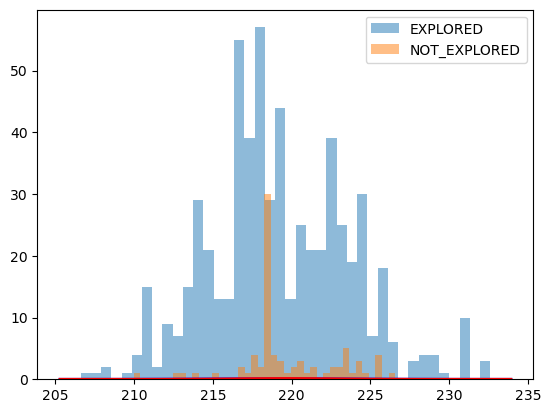

In [37]:

plt.hist(explored_mean_list,alpha=0.5,label='EXPLORED',bins=40)
plt.hist(not_explored_mean_list,alpha=0.5,label='NOT_EXPLORED',bins=40)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu1, std1) 
q = norm.pdf(y, mu2, std2)
plt.plot(x, p, 'k', linewidth=2,color='blue')
plt.plot(y, q, 'k', linewidth=2,color='red')


plt.legend(loc='upper right')
resolution_value = 900
plt.savefig("output_best.png", format="png", dpi=resolution_value)
plt.show()